#EECS 504 PS2: Signal Processing

Please provide the following information 
(e.g. Andrew Owens, ahowens):

[Mohammadreza] [Tavasoli Naeini], [69124256]




# Starting

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

In [ ]:
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt, urllib, os
import scipy.ndimage # For image filtering
from scipy import signal
from scipy import fft
import imageio # For loading images
import cv2

# cv2.imshow does not work in Colab, we use cv2_imshow instead
from google.colab.patches import cv2_imshow

# Problem 2.1 2D DFT and convolution theorem 

2.1 (c) 

In this problem, we compare the output of a Gaussian filter through i) direct convolution in the spatial domain and ii) multiplication in the frequency domain.

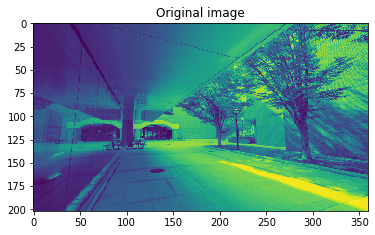

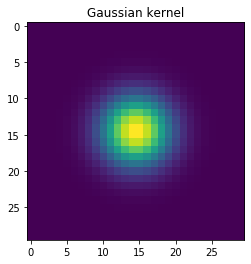

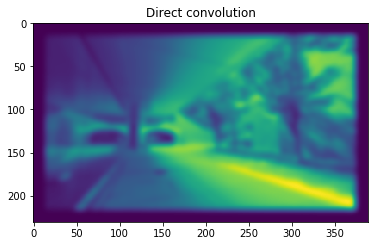

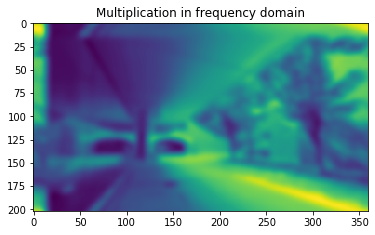

In [ ]:
img_url = 'https://mapproxy.studentlife.umich.edu/images/electrical-engineering-and-computer-science-bld/XP2S3935.jpg'
with open('eecs.jpg', 'wb') as out:
  out.write(urllib.request.urlopen(img_url).read())

img = cv2.imread('eecs.jpg')
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img = cv2.resize(img, None, fx=0.25, fy=0.25)
plt.figure()
plt.imshow(img)
plt.title('Original image')
plt.show()

# make a 2-D kernel Gaussian kernel
t = np.linspace(-10, 10, 30)
bump = np.exp(-0.1*t**2)
bump /= np.trapz(bump) # normalize the integral to 1
kernel = bump[:, np.newaxis] * bump[np.newaxis, :]
plt.imshow(kernel)
plt.title('Gaussian kernel')
plt.show()

# convolution in spatial domain
# ===== your code here! =====
img1=scipy.signal.convolve2d (img,kernel)
# ===== end of code =====
plt.figure()
plt.title('Direct convolution')
plt.imshow(img1)
plt.show()

# multiplication in frequency domain
# shape variable needs to be inputted to the fft2 function
shape = (img.shape[0]+kernel.shape[0]-1, img.shape[1]+kernel.shape[1]-1)
# ===== your code here! =====
k=np.pad(kernel,[(0,202-30),(0,360-30)])
img2=np.real(fft.ifft2(fft.fft2(img)*fft.fft2(k)))
# ===== end of code =====

plt.figure()
plt.title('Multiplication in frequency domain')
plt.imshow(img2)
plt.show()

# Problem 2.2 Image blending

(a) In this problem, we construct a Laplacian pyramids with 4 levels. We use the Laplacian pyramid to reconstruct the orignal image.

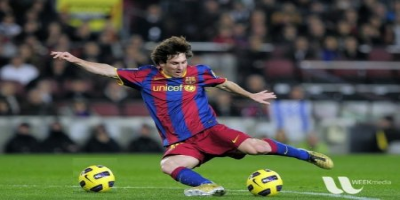

In [ ]:
img_url = 'https://docs.opencv.org/master/roi.jpg'
with open('messi.jpg', 'wb') as out:
  out.write(urllib.request.urlopen(img_url).read())

img = cv2.imread('messi.jpg')
img = cv2.resize(img, (400,200))
cv2_imshow(img)

In [ ]:
num_levels = 4 # including the original img

def pyr_up(p, kernel_size=(5,5)):
  '''
  Upsample the pyramid image to get the upper level. 

  Input:
    p: M x N x C array

  Return: 
    out: 2M x 2N x C array
  '''
  # ===== your code here! =====
  out=cv2.pyrUp(p)
  # ===== end of code =====

  return out

def pyr_down(p, kernel_size=(5,5)):

    '''
    Downsample the pyramid image to get the lower level. 

    Input:
      p: M x N * C array

    Return: 
      out: M/2 x N/2 * C array
    '''
    # ===== your code here! =====
    out=cv2.pyrDown(p)
    # ===== end of code =====

    return out

def gaussian_pyramid(img, num_levels):

  '''
  Input
    img: N x M x C array

  Return
    gp: list, the generated levels of the Gaussian pyramids
  '''

  # ===== your code here! =====
  G = img.copy()
  gp = [G]
  for i in range(num_levels):
    G = cv2.pyrDown(G)
    gp.append(G)

  # ===== end of code =====

  return gp

def laplacian_pyramid(gp, num_levels):
  '''
  Input
    gp: list, Gaussian pyramids

  Return
    lp: list, Laplacian pyramids
  '''
  # ===== your code here! =====
  lp = [gp[num_levels-1]]
  for i in range(num_levels-1,0,-1):
    GE = cv2.pyrUp(gp[i])
    L = cv2.subtract(gp[i-1],GE)
    lp.append(L)

  # ===== end of code =====

  return lp

def reconstruct_img(lp):
  '''
  reconstruct images using the laplacian pyramid.

  Input:
    lp: list, Laplacian pyramids

  Return:
    recon_img: array, reconstructed image
  '''
  recon_img = lp[0]
  for i in range(1, len(lp)):
    # ===== your code here! =====
    recon_img  = cv2.pyrUp(recon_img)
    recon_img = cv2.add(recon_img, lp[i])

    # ===== end of code =====

  return recon_img

Laplacian pyramid


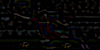

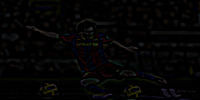

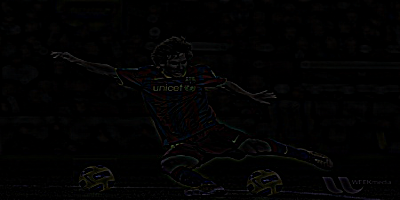

original image


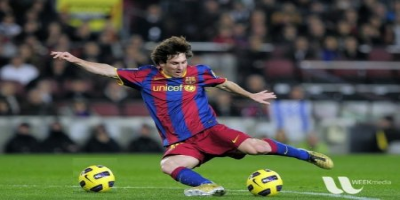

reconstructed image


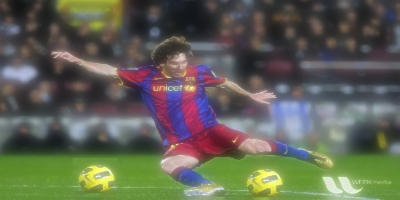

In [ ]:
gp = gaussian_pyramid(img, num_levels)
lp = laplacian_pyramid(gp, num_levels)
recon_img = reconstruct_img(lp)

print('Laplacian pyramid')
for L in lp:
  cv2_imshow(L)

print('original image')
cv2_imshow(img)

print('reconstructed image')
cv2_imshow(recon_img)

# 2.2 (b) Blend two images


In [ ]:
base_url = 'https://inst.eecs.berkeley.edu/~cs194-26/fa17/upload/files/proj3/cs194-26-acr/img/multires1/'
for name in ['orange.jpg', 'apple.jpg']:
  with open(name, 'wb') as out:
    url = os.path.join(base_url, name)
    out.write(urllib.request.urlopen(url).read())

In [ ]:
img1 = cv2.imread('apple.jpg')
img2 = cv2.imread('orange.jpg')
img1 = cv2.resize(img1, None, fx=0.5, fy=0.5)
img2 = cv2.resize(img2, None, fx=0.5, fy=0.5)

mask = np.zeros_like(img1)
mask[:mask.shape[1]//2, :, :] = 1

In [ ]:
def pyr_blend(img1, img2, mask, num_levels=6):
  '''
  This function produces the Laplacian pyramid blend of two images.

  Input
    type img1: N x M x C uint8 array
    type img2: N x M x C uint8 array
    type mask: N x M x C array, all elements are either 0s or 1s
    type num_level: int, height of the pyramids
  
  Return
    img_blend: N x M x C uint8 array
  '''

  # build Gaussian pyramids for img1, img2, and mask
  gp1, gp2, gpm = gaussian_pyramid(img1, num_levels), gaussian_pyramid(img2, num_levels), gaussian_pyramid(mask, num_levels)

  # build Laplaican pyramids for img1 and img2 
  lp1, lp2, lpm = laplacian_pyramid(gp1, num_levels), laplacian_pyramid(gp2, num_levels), laplacian_pyramid(gpm, num_levels)
 
  # blend two images starting from the level with lowest resolution
  # ===== your code here! =====
  LS = []
  for l1,l2,lm in zip(lp1,lp2,lpm):
    ls=l1*lm+l1*(1-lm)
    LS.append(ls)
  img_blend= LS[0]
  for i in range(1,num_levels):
    img_blend = cv2.pyrUp(img_blend)
    img_blend = cv2.add(img_blend, LS[i])

  # ===== end of code =====

  return img_blend

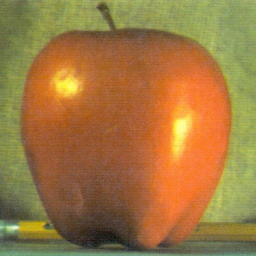

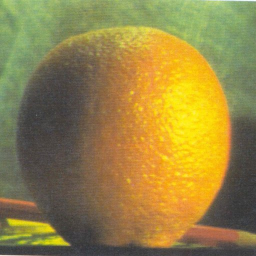

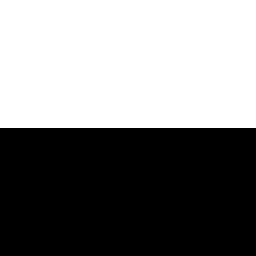

In [ ]:
cv2_imshow(img1)
cv2_imshow(img2)
cv2_imshow(mask * 255)

Number of levels = 1


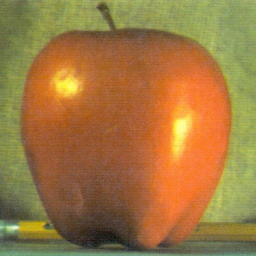

Number of levels = 2


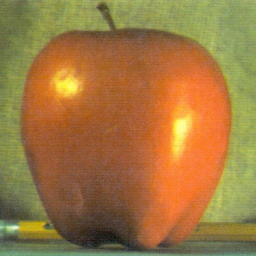

Number of levels = 3


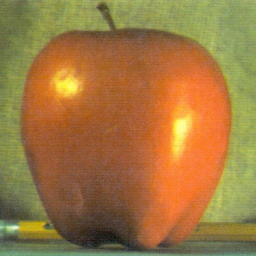

Number of levels = 4


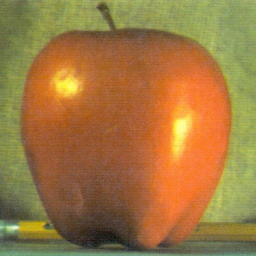

Number of levels = 5


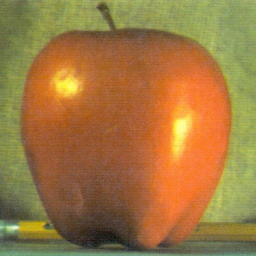

Number of levels = 6


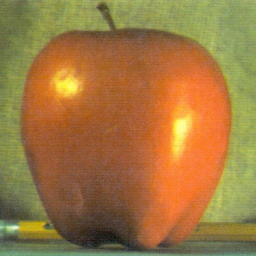

In [ ]:
# Laplacian pyramid blend with different levels
for n_l in range(1, 7):
  img_blend = pyr_blend(img1.astype(float), img2.astype(float), mask.astype(float), num_levels=n_l)
  print('Number of levels = {}'.format(n_l))
  cv2_imshow(img_blend)